Loading data...
Demand data: 196513 rows
Temperature data: 220326 rows

Sample demand data:
        DATETIME  TOTALDEMAND REGIONID
0  1/1/2010 0:00      8038.00     NSW1
1  1/1/2010 0:30      7809.31     NSW1
2  1/1/2010 1:00      7483.69     NSW1
3  1/1/2010 1:30      7117.23     NSW1
4  1/1/2010 2:00      6812.03     NSW1

Sample temperature data:
    LOCATION       DATETIME  TEMPERATURE
0  Bankstown  1/1/2010 0:00         23.1
1  Bankstown  1/1/2010 0:01         23.1
2  Bankstown  1/1/2010 0:30         22.9
3  Bankstown  1/1/2010 0:50         22.7
4  Bankstown  1/1/2010 1:00         22.6

Preparing datetime formats for matching...

Aggregating temperature data to match demand timestamps...
Aggregated temperature data: 98075 rows

Matching demand with temperature data...
Matched data: 196149 rows

Basic statistics:
Correlation between Temperature and Demand: 0.1490

Demand by Temperature Range:
  TEMP_RANGE          mean          std  count
0      < 0°C   8094.539375   919.398042    

C:\Users\waseem\AppData\Local\Temp\ipykernel_22160\3369540576.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demand_by_temp = merged_df.groupby('TEMP_RANGE')['TOTALDEMAND'].agg(['mean', 'std', 'count']).reset_index()



Analysis complete. Visualizations saved.

Key Findings:
1. Overall correlation between temperature and demand: 0.1490
2. Temperature with lowest average demand: 19.0°C
3. Correlation in cold temperatures (below 19.0°C): -0.1217
4. Correlation in hot temperatures (above 19.0°C): 0.5502
5. Correlation in extreme temperatures:
   - Cold (<5°C): 0.0117
   - Hot (>35°C): 0.3878

6. Demand distribution by temperature range:
  TEMP_RANGE  10th Percentile  Median (50th)  90th Percentile  Count
0      < 0°C         7293.860       7826.060         9461.995     16
1      0-5°C         6739.225       7580.005         9536.670   2710
2     5-10°C         6444.164       7899.400        10234.773  19550
3    10-15°C         6255.896       8232.980        10245.993  42350
4    15-20°C         6237.962       7744.020         9118.938  62603
5    20-25°C         6695.152       8086.395         9366.142  51528
6    25-30°C         7423.539       9150.565        10741.518  14270
7    30-35°C         8112

C:\Users\waseem\AppData\Local\Temp\ipykernel_22160\3369540576.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  demand_distribution = merged_df.groupby('TEMP_RANGE')['TOTALDEMAND'].agg([



This analysis suggests a likely U-shaped relationship between temperature and demand,
where both very cold and very hot temperatures result in higher electricity demand,
likely due to heating and cooling requirements respectively.


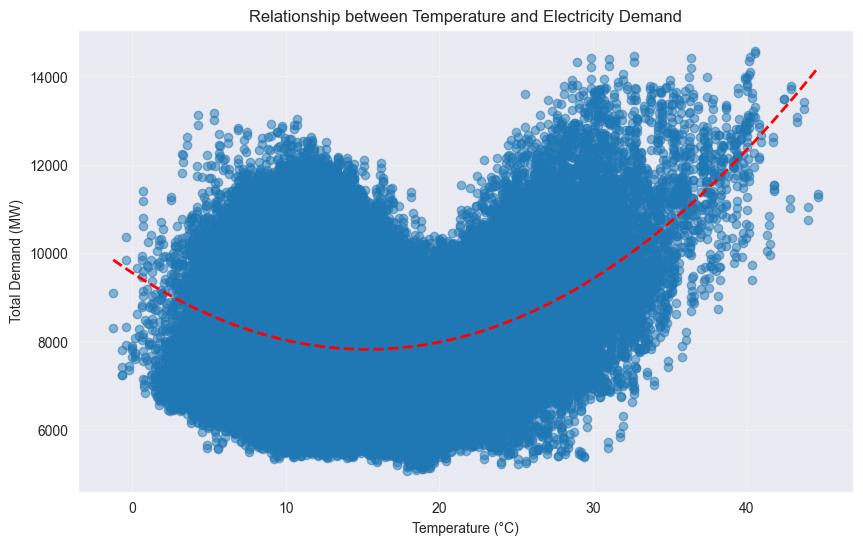

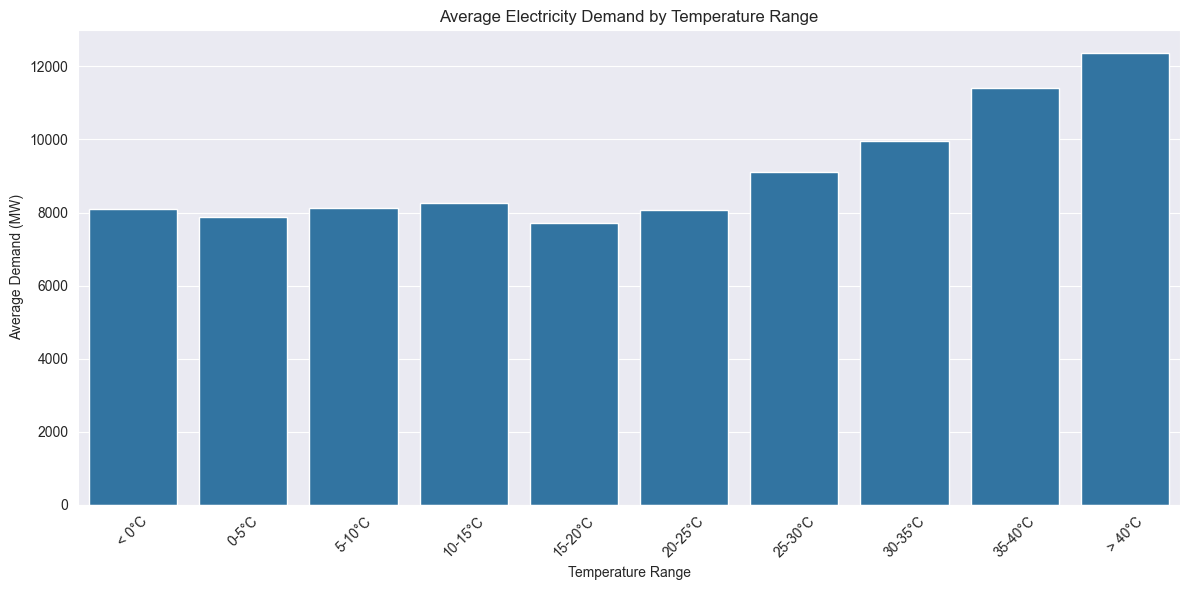

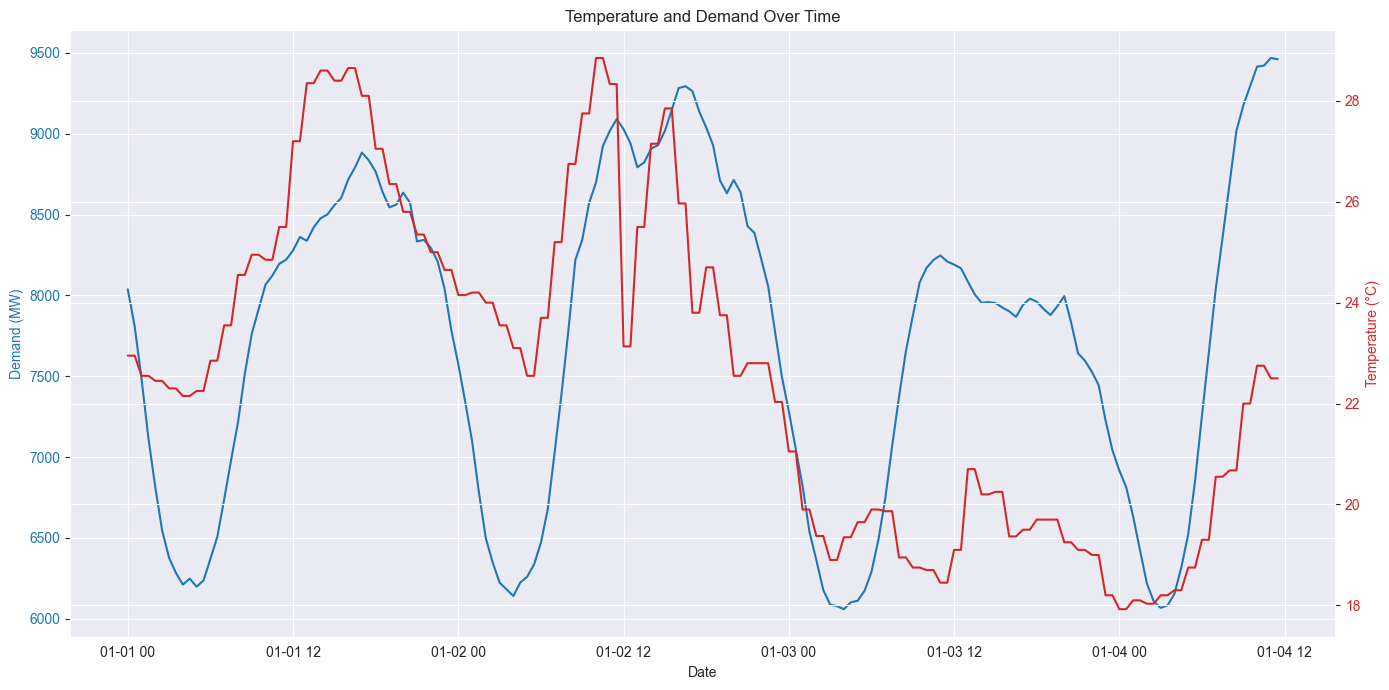

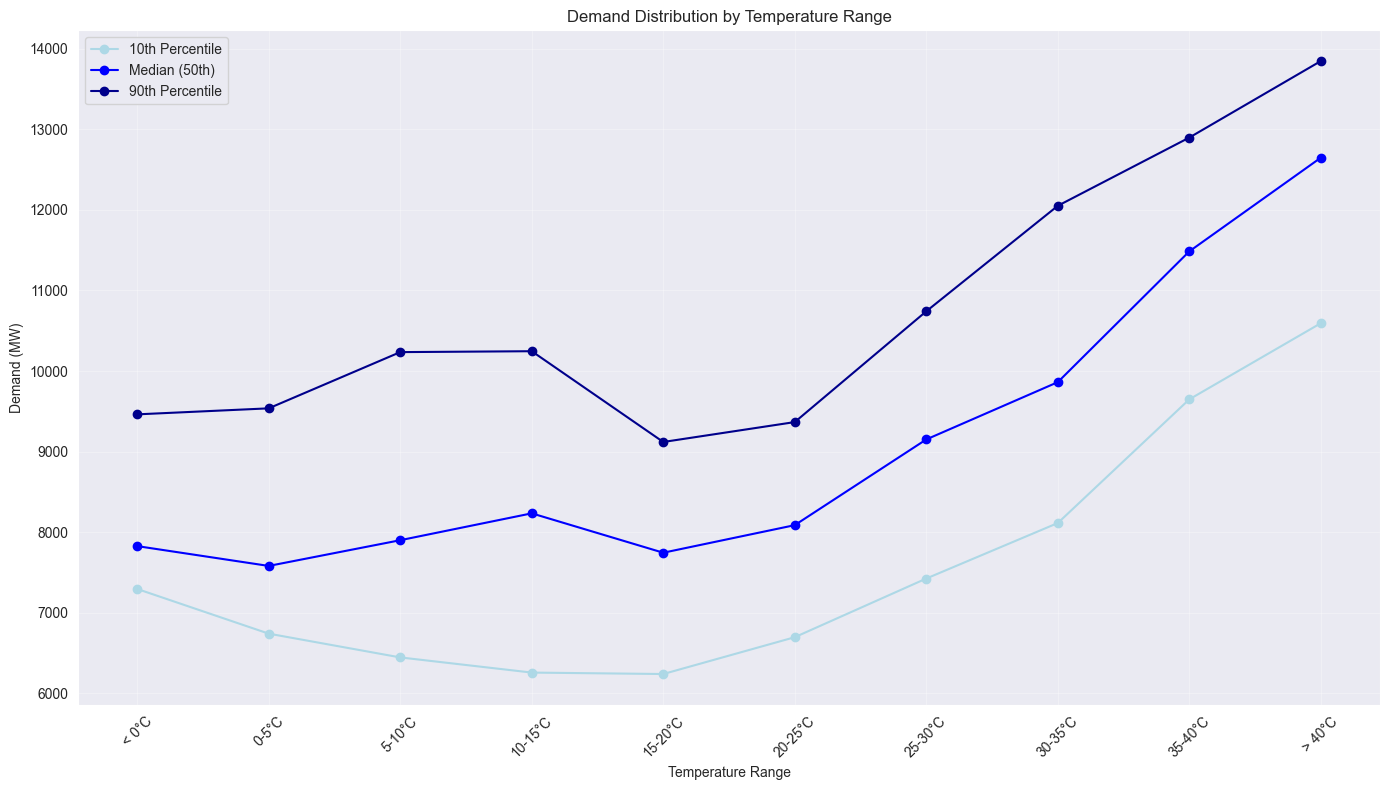

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# File paths
demand_path = r"C:\Users\waseem\Desktop\UNSW\Graduation Project\totaldemand_nsw.csv" # Change Path
temperature_path = r"C:\Users\waseem\Desktop\UNSW\Graduation Project\temperature_nsw.csv" # Chnage Path

# Load data

demand_df = pd.read_csv(demand_path)
temperature_df = pd.read_csv(temperature_path)

print(f"Demand data: {len(demand_df)} rows")
print(f"Temperature data: {len(temperature_df)} rows")

# Display sample data
print("\nSample demand data:")
print(demand_df.head())
print("\nSample temperature data:")
print(temperature_df.head())

# Convert date formats for matching
print("\nPreparing datetime formats for matching...")

def convert_demand_datetime(demand_datetime):
    """Convert demand datetime to a standard format"""
    try:
        dt = datetime.strptime(demand_datetime, '%d/%m/%Y %H:%M')
        return dt.strftime('%Y-%m-%d %H:%M')
    except:
        return demand_datetime

def convert_temp_datetime(temp_datetime):
    """Convert temperature datetime to a standard format"""
    try:
        dt = datetime.strptime(temp_datetime, '%d/%m/%Y %H:%M')
        return dt.strftime('%Y-%m-%d %H:%M')
    except:
        try:
            # Try alternative format if the first one fails
            dt = datetime.strptime(temp_datetime, '%d/%m/%Y %H:%M:%S')
            return dt.strftime('%Y-%m-%d %H:%M')
        except:
            return temp_datetime

# Add standardized datetime columns
demand_df['DATETIME_STD'] = demand_df['DATETIME'].apply(convert_demand_datetime)
temperature_df['DATETIME_STD'] = temperature_df['DATETIME'].apply(convert_temp_datetime)


# We'll create an hourly aggregation to match with demand data
print("\nAggregating temperature data to match demand timestamps...")

# Extract hour component for grouping
temperature_df['HOUR'] = temperature_df['DATETIME_STD'].apply(
    lambda x: x[:13] if len(x) >= 13 else x  # in order to get YYYY-MM-DD HH part
)

# Aggregate temperature by hour (average if multiple readings per hour)
hourly_temp = temperature_df.groupby(['HOUR', 'LOCATION'])['TEMPERATURE'].mean().reset_index()
print(f"Aggregated temperature data: {len(hourly_temp)} rows")

# Matching demand with temperature based on datetime
print("\nMatching demand with temperature data...")

# Extract hour component from demand timestamps too
demand_df['HOUR'] = demand_df['DATETIME_STD'].apply(
    lambda x: x[:13] if len(x) >= 13 else x  # Get YYYY-MM-DD HH part
)

# Merge demand with temperature
merged_df = pd.merge(
    demand_df,
    hourly_temp,
    left_on='HOUR',
    right_on='HOUR',
    how='inner'
)

print(f"Matched data: {len(merged_df)} rows")

# If the merge didn't work well, try a different approach
if len(merged_df) < len(demand_df) * 0.5:  # Less than 50% matched
    print("Low match rate. Trying alternative approach...")

    # Create a date-only field for matching by day
    demand_df['DATE'] = demand_df['DATETIME_STD'].apply(lambda x: x[:10] if len(x) >= 10 else None)
    temperature_df['DATE'] = temperature_df['DATETIME_STD'].apply(lambda x: x[:10] if len(x) >= 10 else None)

    # Calculate daily average temperature
    daily_temp = temperature_df.groupby(['DATE', 'LOCATION'])['TEMPERATURE'].mean().reset_index()

    # Merge by date
    merged_df = pd.merge(
        demand_df,
        daily_temp,
        on='DATE',
        how='inner'
    )

    print(f"Date-based match: {len(merged_df)} rows")

# Basic statistics
print("\nBasic statistics:")
print(f"Correlation between Temperature and Demand: {merged_df['TEMPERATURE'].corr(merged_df['TOTALDEMAND']):.4f}")

# Calculate statistics by temperature ranges
print("\nDemand by Temperature Range:")
temp_bins = [-10, 0, 5, 10, 15, 20, 25, 30, 35, 40, 50]
temp_labels = ['< 0°C', '0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C', '30-35°C', '35-40°C', '> 40°C']
merged_df['TEMP_RANGE'] = pd.cut(merged_df['TEMPERATURE'], bins=temp_bins, labels=temp_labels)

# Group by temperature range
demand_by_temp = merged_df.groupby('TEMP_RANGE')['TOTALDEMAND'].agg(['mean', 'std', 'count']).reset_index()
print(demand_by_temp)

# Visualizations
print("\nCreating visualizations...")

# 1. Scatter plot of Temperature vs Demand
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['TEMPERATURE'], merged_df['TOTALDEMAND'], alpha=0.5)
plt.title('Relationship between Temperature and Electricity Demand')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Demand (MW)')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(merged_df['TEMPERATURE'], merged_df['TOTALDEMAND'], 2)  # Quadratic fit
p = np.poly1d(z)
temp_range = np.linspace(merged_df['TEMPERATURE'].min(), merged_df['TEMPERATURE'].max(), 100)
plt.plot(temp_range, p(temp_range), "r--", linewidth=2)

plt.savefig('temperature_vs_demand_scatter.png')

# 2. Average Demand by Temperature Range
plt.figure(figsize=(12, 6))
sns.barplot(x='TEMP_RANGE', y='mean', data=demand_by_temp)
plt.title('Average Electricity Demand by Temperature Range')
plt.xlabel('Temperature Range')
plt.ylabel('Average Demand (MW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('avg_demand_by_temp_range.png')

# 3. Time series plot of temperature and demand (sample period)
if len(merged_df) > 0:
    # Sort by datetime
    if 'DATETIME_STD' in merged_df.columns:
        merged_df['DATETIME_OBJ'] = pd.to_datetime(merged_df['DATETIME_STD'])
        merged_df = merged_df.sort_values('DATETIME_OBJ')

    # Get a sample period (first 7 days or less)
    sample_period = merged_df.iloc[:min(24*7, len(merged_df))]

    # Create the time series plot
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # Plot demand
    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Demand (MW)', color=color)
    ax1.plot(sample_period['DATETIME_OBJ'], sample_period['TOTALDEMAND'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create second y-axis for temperature
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Temperature (°C)', color=color)
    ax2.plot(sample_period['DATETIME_OBJ'], sample_period['TEMPERATURE'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Temperature and Demand Over Time')
    fig.tight_layout()
    plt.savefig('temperature_demand_time_series.png')

print("\nAnalysis complete. Visualizations saved.")

# Additional insights
print("\nKey Findings:")
print(f"1. Overall correlation between temperature and demand: {merged_df['TEMPERATURE'].corr(merged_df['TOTALDEMAND']):.4f}")

# Find temperature with minimum demand (U-shaped relationship)
grouped = merged_df.groupby(merged_df['TEMPERATURE'].round())['TOTALDEMAND'].mean()
min_demand_temp = grouped.idxmin()
print(f"2. Temperature with lowest average demand: {min_demand_temp}°C")

# Calculate separate correlations for hot and cold temperatures
if min_demand_temp is not None:
    cold_df = merged_df[merged_df['TEMPERATURE'] < min_demand_temp]
    hot_df = merged_df[merged_df['TEMPERATURE'] > min_demand_temp]

    cold_corr = cold_df['TEMPERATURE'].corr(cold_df['TOTALDEMAND'])
    hot_corr = hot_df['TEMPERATURE'].corr(hot_df['TOTALDEMAND'])

    print(f"3. Correlation in cold temperatures (below {min_demand_temp}°C): {cold_corr:.4f}")
    print(f"4. Correlation in hot temperatures (above {min_demand_temp}°C): {hot_corr:.4f}")

# Calculate correlation for extreme temperatures (<5°C and >30°C)
extreme_cold_df = merged_df[merged_df['TEMPERATURE'] < 5]
extreme_hot_df = merged_df[merged_df['TEMPERATURE'] > 30]

extreme_cold_corr = extreme_cold_df['TEMPERATURE'].corr(extreme_cold_df['TOTALDEMAND']) if len(extreme_cold_df) > 2 else float('nan')
extreme_hot_corr = extreme_hot_df['TEMPERATURE'].corr(extreme_hot_df['TOTALDEMAND']) if len(extreme_hot_df) > 2 else float('nan')

print(f"5. Correlation in extreme temperatures:")
print(f"   - Cold (<5°C): {extreme_cold_corr:.4f}" if not np.isnan(extreme_cold_corr) else "   - Cold (<5°C): Not enough data")
print(f"   - Hot (>35°C): {extreme_hot_corr:.4f}" if not np.isnan(extreme_hot_corr) else "   - Hot (>35°C): Not enough data")
